In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim

from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score,classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Bidirectional
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore")

C:\Users\saket\anaconda3\envs\Env_1\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
df = pd.read_csv('C:\\Users\\saket\\Downloads\\questions.csv')

In [5]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404346,404346,789792,789793,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404347,404347,789794,789795,Do you believe there is life after death?,Is it true that there is life after death?,1
404348,404348,789796,789797,What is one coin?,What's this coin?,0
404349,404349,789798,789799,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [92]:
new_df = df.sample(30000,random_state=2)
new_df['is_duplicate'].value_counts()

0    18918
1    11082
Name: is_duplicate, dtype: int64

In [93]:
new_df[['question1','question2','is_duplicate']].iloc[8]

question1       How do I improve my English writing and speaki...
question2       How can I improve my writing skills to become ...
is_duplicate                                                    1
Name: 45359, dtype: object

In [94]:
#created a function for preprocessing the data

def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [95]:
#trying the preprocess function

preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [96]:
#preprocessing the data
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [97]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
339499,339499,665522,665523,why was cyrus mistry removed as the chairman o...,why did the tata sons sacked cyrus mistry,1
289521,289521,568878,568879,by what age would you think a man should be ma...,when my wrist is extended i feel a shock and b...,0
4665,4665,9325,9326,how would an arbitrageur seek to capitalize gi...,how would an arbitrageur seek to capitalize gi...,0
54203,54203,107861,107862,why did quora mark my question as incomplete,why does quora detect my question as an incomp...,1
132566,132566,262554,91499,what is it like working with pivotal labs as a...,what is it like to work at pivotal labs,0


In [98]:
#creating new features

new_df['q1_len'] = new_df['question1'].str.len() 
new_df['q2_len'] = new_df['question2'].str.len()

In [99]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))

In [100]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [101]:
new_df['word_common'] = new_df.apply(common_words, axis=1)

In [102]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [103]:
new_df['word_total'] = new_df.apply(total_words, axis=1)

In [104]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)

In [105]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [106]:
token_features = new_df.apply(fetch_token_features, axis=1)

new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [33]:
pip install distance

     ------------------------------------ 180.3/180.3 kB 402.9 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16282 sha256=4f1307e5a9f820080a7d988f7f5088ee85c09bcb0d75080ad8f4a878f2940ac2
  Stored in directory: c:\users\saket\appdata\local\pip\cache\wheels\6a\41\b0\39f403bd1fb459600f3ced3f74e8e88ffd5a409584a043785a
Successfully built distance
Note: you may need to restart the kernel to use updated packages.


In [107]:
import distance

In [108]:
def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [109]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [38]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [110]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [111]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [112]:
print(new_df.shape)

(30000, 28)


In [113]:
ques_df = new_df[['question1','question2']]
ques_df.head(4)

,question1,question2
339499,why was cyrus mistry removed as the chairman o...,why did the tata sons sacked cyrus mistry
289521,by what age would you think a man should be ma...,when my wrist is extended i feel a shock and b...
4665,how would an arbitrageur seek to capitalize gi...,how would an arbitrageur seek to capitalize gi...
54203,why did quora mark my question as incomplete,why does quora detect my question as an incomp...


In [114]:
questions = list(ques_df['question1']) + list(ques_df['question2'])

In [115]:
ques_sent = []
for sentence in questions:
    ques_sent.append(gensim.utils.simple_preprocess(sentence))

In [116]:
model  = gensim.models.Word2Vec(window=2,min_count=3,sg=1,vector_size=100)

In [117]:
model.build_vocab(ques_sent)

In [118]:
model.train(corpus_iterable=ques_sent,total_examples= model.corpus_count, epochs=model.epochs)

(2167267, 3140640)

In [119]:
w2v = dict(zip(model.wv.index_to_key, (model.wv.vectors.round(3))))

In [120]:
w2v['pakistan']

array([-0.612,  0.025, -0.   , -0.189, -0.307, -0.261,  0.14 ,  0.554,
        0.145, -0.582,  0.133, -0.611, -0.09 ,  0.018,  0.129, -0.106,
        0.257, -0.251, -0.048, -0.423, -0.26 ,  0.35 , -0.2  , -0.031,
        0.301,  0.038, -0.259, -0.067, -0.749, -0.181,  0.005, -0.023,
        0.225, -0.505, -0.277,  0.403,  0.063, -0.215,  0.263, -0.306,
       -0.141,  0.14 , -0.334, -0.637, -0.034, -0.022,  0.12 ,  0.21 ,
        0.108,  0.218,  0.319, -0.172, -0.005,  0.132, -0.023,  0.093,
        0.282, -0.4  , -0.228,  0.006,  0.321, -0.178,  0.499,  0.12 ,
       -0.396,  0.416, -0.149, -0.012, -0.714,  0.311,  0.209,  0.516,
        0.303, -0.176,  0.469, -0.09 , -0.186, -0.218, -0.162, -0.039,
        0.016, -0.105, -0.646,  0.159, -0.251, -0.509,  0.334,  0.456,
       -0.068,  0.145,  0.546,  0.38 ,  0.358, -0.054,  0.649,  0.626,
       -0.097, -0.108, -0.304,  0.018], dtype=float32)

In [121]:
w2v['india']

array([-0.14 ,  0.07 , -0.192, -0.392, -0.351, -0.59 , -0.263,  0.481,
        0.165, -0.681,  0.482, -0.471,  0.13 ,  0.512,  0.225,  0.391,
       -0.181,  0.03 , -0.222, -0.506,  0.161,  0.163, -0.096, -0.004,
        0.096, -0.208, -0.189, -0.056, -0.352,  0.041, -0.021, -0.31 ,
        0.258, -0.932, -0.57 ,  0.508, -0.209,  0.028,  0.064, -0.393,
        0.481,  0.29 , -0.21 , -0.54 ,  0.462,  0.063, -0.017, -0.133,
        0.259, -0.092,  0.357, -0.57 , -0.008,  0.473,  0.02 , -0.221,
        0.351, -0.781,  0.229, -0.403,  0.681, -0.052,  0.007,  0.354,
       -0.414,  0.685, -0.183,  0.141, -0.475,  0.134,  0.418,  0.098,
        0.221,  0.336,  0.501,  0.375, -0.313,  0.136, -0.169, -0.011,
       -0.193,  0.053, -0.61 ,  0.002, -0.61 , -0.405, -0.185, -0.045,
        0.23 ,  0.643,  0.175,  0.135,  0.368, -0.234,  0.478,  0.355,
       -0.448, -0.089, -0.306,  0.565], dtype=float32)

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [123]:
tfidf1 = TfidfVectorizer()

In [124]:
tfidf1.fit_transform(questions)

<60000x26168 sparse matrix of type '<class 'numpy.float64'>'
	with 605290 stored elements in Compressed Sparse Row format>

In [125]:
a = tfidf1.vocabulary_.items()

In [126]:
word2weight = [(w, round(tfidf1.idf_[i])) for w, i in tfidf1.vocabulary_.items()]

In [127]:
word2weight = dict(word2weight)

In [128]:
model.wv.similar_by_word('pakistan',topn=15)

[('russia', 0.8999234437942505),
 ('china', 0.8936740159988403),
 ('south', 0.8521349430084229),
 ('korea', 0.8484773635864258),
 ('relations', 0.847938060760498),
 ('japan', 0.8470012545585632),
 ('europe', 0.8461410999298096),
 ('vietnam', 0.8397872447967529),
 ('north', 0.8371185660362244),
 ('nuclear', 0.8362182974815369),
 ('military', 0.8312198519706726),
 ('africa', 0.829288125038147),
 ('asia', 0.8254243731498718),
 ('bangladesh', 0.8183507919311523),
 ('malaysia', 0.8160591125488281)]

In [129]:
model.wv.similar_by_word('actor',topn=15)

[('actress', 0.9186648726463318),
 ('film', 0.8912929892539978),
 ('anime', 0.8866848349571228),
 ('comedy', 0.8836644291877747),
 ('soccer', 0.8834263682365417),
 ('inspirational', 0.8778414726257324),
 ('sexiest', 0.8775463104248047),
 ('player', 0.876923143863678),
 ('spiritual', 0.8762649297714233),
 ('malayalam', 0.8730223774909973),
 ('scenes', 0.8726590871810913),
 ('hollywood', 0.8707504868507385),
 ('team', 0.8681944012641907),
 ('inspiring', 0.8681011199951172),
 ('comic', 0.8676729798316956)]

In [157]:
# def document_vector(doc):
#     if len(doc.split()) == 0:
#         return np.zeros(shape=(100))
#     elif len(doc.split()) == 1:
#         return np.zeros(shape=(100))
#     else:
# #         doc = [word for word in doc.split() if word in model.wv.index_to_key]
# #         return np.mean(model.wv[doc],axis=0).round(2)
#         doc_vec = []
#         tfidf_weight_sum = 0
#         for word in doc.split():
#             if word in w2v.keys() and word in word2weight.keys():
#                 tfidf_weight = word2weight[word]*doc.split().count(word)/len(doc.split())
#                 product = (w2v[word]*tfidf_weight)
#                 doc_vec.append(product)
#                 tfidf_weight_sum = tfidf_weight_sum + tfidf_weight
#                 #print(f"weight of {word} : {word2weight[word]}")
#                 #print(f"word vector of {word} : {w2v[word]}")
#                 #print(product)\n",
#         #print(doc_vec)
#         if len(doc_vec) == 0:
#             return np.round(np.sum(doc_vec,axis=0)/1,3)
#         else:
#             return np.round(np.sum(doc_vec,axis=0)/tfidf_weight_sum,3)

def document_vector(doc):
    if len(doc.split()) == 0:
        return np.zeros(shape=(100))
    elif len(doc.split()) == 1:
        return np.zeros(shape=(100))
    else:
        doc_vec = []
        tfidf_weight_sum = 0
        for word in doc.split():
            if word in w2v.keys() and word in word2weight.keys():
                tfidf_weight = word2weight[word] * doc.split().count(word) / len(doc.split())
                product = (w2v[word] * tfidf_weight)
                doc_vec.append(product)
                tfidf_weight_sum = tfidf_weight_sum + tfidf_weight
        
        if len(doc_vec) == 0:
            return np.zeros(shape=(100))  # Return zeros if no valid word vectors are found
        else:
            return np.round(np.sum(doc_vec, axis=0) / tfidf_weight_sum, 3)

In [158]:
from tqdm import tqdm

In [159]:
X = []
for doc in tqdm(ques_df['question1']):
    X.append(document_vector(doc))

100%|██████████| 30000/30000 [00:01<00:00, 17933.53it/s]


In [160]:
X2 = []
for doc in tqdm(ques_df['question2']):
    X2.append(document_vector(doc))

100%|██████████| 30000/30000 [00:01<00:00, 16886.13it/s]


In [161]:
X[6].shape

(100,)

In [162]:
import numpy as np

max_length = 100  # Choose the maximum length for your vectors
X = []

for doc in tqdm(ques_df['question1']):
    vector = document_vector(doc)
    padded_vector = np.pad(vector, (0, max_length - len(vector)), mode='constant')
    X.append(padded_vector)

X = np.array(X)

100%|██████████| 30000/30000 [00:02<00:00, 12557.89it/s]


In [163]:
X = np.array(X)

In [164]:
X2 = np.array(X2)

In [165]:
temp_df1 = pd.DataFrame(X, index= new_df.index)
temp_df2 = pd.DataFrame(X2, index= new_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)

In [166]:
temp_df.shape

(30000, 200)

In [167]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)

(30000, 23)


In [168]:
complete_df = pd.concat([final_df, temp_df], axis=1)
print(complete_df.shape)
complete_df.head()

(30000, 223)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,90,91,92,93,94,95,96,97,98,99
339499,1,57,41,11,8,6,19,0.32,0.799984,0.666656,...,0.369,0.084,0.012,0.374,0.528,0.178,-0.067,-0.138,0.235,-0.029
289521,0,51,104,11,23,3,33,0.09,0.000000,0.000000,...,0.187,0.120,0.076,0.129,0.362,0.042,0.213,0.041,0.215,0.013
4665,0,123,122,42,42,18,38,0.47,0.923070,0.923070,...,0.193,0.090,0.061,0.032,0.346,0.155,-0.033,-0.133,0.161,-0.040
54203,1,44,59,8,10,6,18,0.33,0.749981,0.599988,...,0.380,0.273,-0.130,0.202,0.678,0.169,0.043,-0.046,0.014,-0.006
132566,0,53,39,11,9,6,20,0.30,0.749981,0.599988,...,0.183,0.188,0.281,0.134,0.420,0.078,0.132,-0.007,0.102,-0.043


In [169]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(complete_df.iloc[:,1:].values,complete_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [175]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_stdscaled = scaler.transform(X_train)
X_test_stdscaled = scaler.transform(X_test)

In [176]:
# Reshape the input data for LSTM
X_train_lstm = np.reshape(X_train_stdscaled, (X_train_stdscaled.shape[0], X_train_stdscaled.shape[1], 1))
X_test_lstm = np.reshape(X_test_stdscaled, (X_test_stdscaled.shape[0], X_test_stdscaled.shape[1], 1))

In [177]:
# Define the BiLSTM model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(128), input_shape=(X_train_lstm.shape[1], 1)))
bilstm_model.add(Dense(1, activation='sigmoid'))

In [178]:
# Compile the model
bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [179]:
# Train the BiLSTM model
hist = bilstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=64,validation_data=(X_test_lstm, y_test))

Epoch 1/10
375/375 [==============================] - 679s 2s/step - loss: 0.5482 - accuracy: 0.6817 - val_loss: 0.5328 - val_accuracy: 0.6868
Epoch 2/10
375/375 [==============================] - 663s 2s/step - loss: 0.5297 - accuracy: 0.6954 - val_loss: 0.5226 - val_accuracy: 0.7043
Epoch 3/10
375/375 [==============================] - 666s 2s/step - loss: 0.5162 - accuracy: 0.7053 - val_loss: 0.5102 - val_accuracy: 0.7075
Epoch 4/10
375/375 [==============================] - 654s 2s/step - loss: 0.5037 - accuracy: 0.7158 - val_loss: 0.4961 - val_accuracy: 0.7202
Epoch 5/10
375/375 [==============================] - 658s 2s/step - loss: 0.4950 - accuracy: 0.7242 - val_loss: 0.4852 - val_accuracy: 0.7287
Epoch 6/10
375/375 [==============================] - 686s 2s/step - loss: 0.4862 - accuracy: 0.7292 - val_loss: 0.4749 - val_accuracy: 0.7327
Epoch 7/10
375/375 [==============================] - 678s 2s/step - loss: 0.4794 - accuracy: 0.7371 - val_loss: 0.4682 - val_accuracy: 0.7467

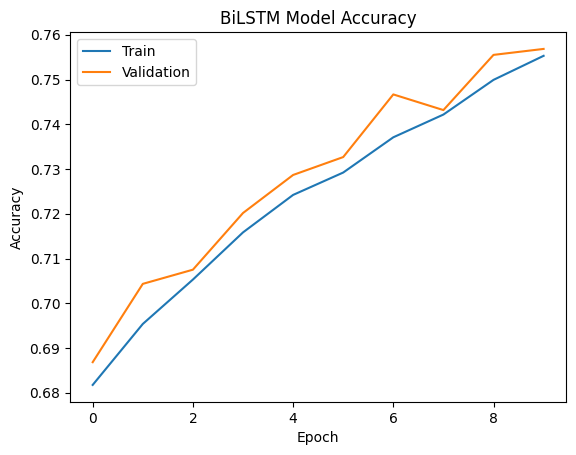

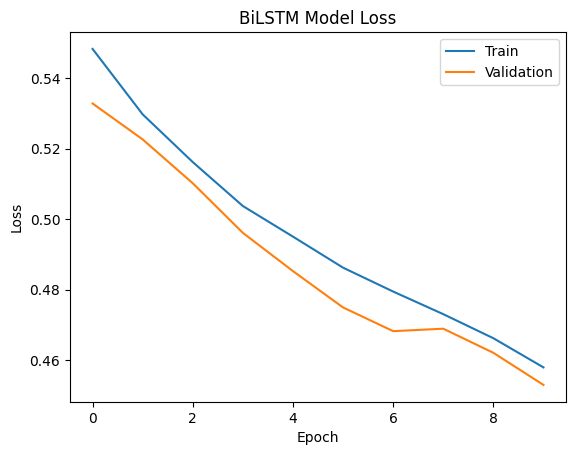

In [180]:
# Plot the training history
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('BiLSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('BiLSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [181]:
# Predict on the test data
y_pred_bilstm = bilstm_model.predict(X_test_lstm)

# Convert the predicted values to 1D array
y_pred_bilstm = np.squeeze(y_pred_bilstm)

188/188 [==============================] - 13s 64ms/step


In [182]:
# Convert y_test to binary format
threshold = 0.5
y_test_binary = np.array(y_test > threshold, dtype=int)
y_pred_bilstm = np.array(y_pred_bilstm > threshold, dtype=int)

In [183]:
# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_bilstm)
print("Accuracy:", accuracy)

Accuracy: 0.7568333333333334


In [184]:
# Get the indices of misclassified and correctly classified examples
bilstm_misclassified_indices = np.where(y_pred_bilstm != y_test)[0]
bilstm_correct_indices = np.where(y_pred_bilstm == y_test)[0]

# Get the corresponding sentences for misclassified examples
bilstm_misclassified_sentences = new_df.iloc[bilstm_misclassified_indices][['question1', 'question2']]

# Get the corresponding sentences for correctly classified examples
bilstm_correct_sentences = new_df.iloc[bilstm_correct_indices][['question1', 'question2']]

bilstm_misclassified_sentences = pd.DataFrame(bilstm_misclassified_sentences)
bilstm_correct_classified_sentences = pd.DataFrame(bilstm_correct_sentences)
bilstm_misclassified_sentences.head()

,question1,question2
54203,why did quora mark my question as incomplete,why does quora detect my question as an incomp...
179825,what do you consider poor middle class wealt...,what is the difference between the poor middl...
296326,what movie should you not watch with your chil...,as your children get to an age where they are ...
45865,do women enjoy double penetration,which type of porn do ladies enjoy watching
335353,why is jayalalithaa so famous,why is jayalalithaa famous


Confusion Matrix:
[[2947  880]
 [ 579 1594]]


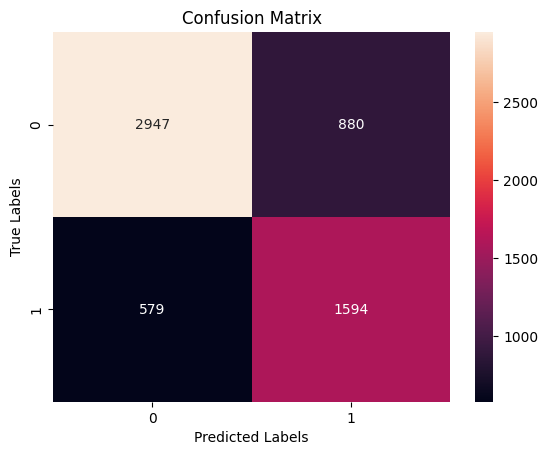

In [185]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_bilstm)
print("Confusion Matrix:")
print(cm)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [186]:
# Calculate precision and recall
precision = precision_score(y_test, y_pred_bilstm)
recall = recall_score(y_test, y_pred_bilstm)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.6443007275666937
Recall: 0.7335480901978831


In [187]:
# Generate classification report
report = classification_report(y_test, y_pred_bilstm)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.77      0.80      3827
           1       0.64      0.73      0.69      2173

    accuracy                           0.76      6000
   macro avg       0.74      0.75      0.74      6000
weighted avg       0.77      0.76      0.76      6000



In [188]:
bilstm_model.save('bilstm_model.h5')